# Using the Extended Joint Trained Framework for transfering a calibration model from one instrument to another.

In this tutorial we will show how to use the Extended Linear Joint Trained Framework (ExtJT) when transfering one a calibration model from one instrument to another without the use of standardization samples.


## Data
We will use the IDRC 2002 Shootout dataset. The dataset contain NIR measurements of tablets measured on two different spectrometers. The dataset is originally divided into 155 samples for calibration, 40 samples for validation and 460 for testing. However, in our case we will combine the calibration and test data into one, and randomly draw calibration and unlabelled samples from this dataset. The resulting calibration model will be tested on the original validation data.

The dataset was originally downloaded from http://eigenvector.com/data/tablets/nir_shootout_2002.mat.


In [1]:
import numpy as np
from ExtJT.get_data import IDRC_2002
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
%matplotlib inline

filename = "data/nir_shootout_2002.mat"
data = IDRC_2002(filename,NIR_range = [0,1750])
X1 = pre.scale(data["Training"]["Instrument 1"],axis=1)
X2 = pre.scale(data["Training"]["Instrument 2"],axis=1)
Y = data["Training"]["References"]

## Data visualization
First, let's take a look at the data. There is a clear difference between the mean of instruments in the regions 600-750nm and 1700-1750. We could just avoid these regions when fitting our model, but we risk loosing chemical information when doing so. Instead we will use the Extended Joint Trained Framework to perform manifold regularization.

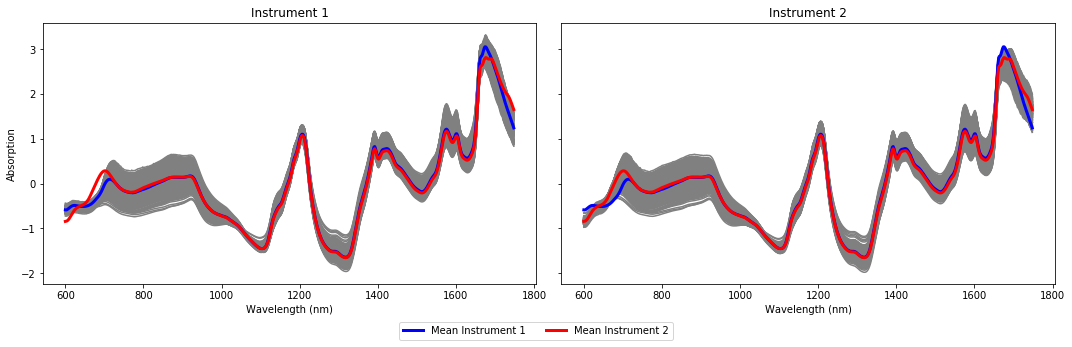

In [2]:
f,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5),sharex=True,sharey=True)
ax1.set_title("Instrument 1")
ax1.plot(data["Wavelength"],X1.T,c="gray",zorder=1)
ax1.plot(data["Wavelength"],X1.mean(axis=0),c="blue",zorder=2,label="Mean Instrument 1",lw=3)
ax1.plot(data["Wavelength"],X2.mean(axis=0),c="red",zorder=2,label="Mean Instrument 2",lw=3)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Absorption")

ax2.set_title("Instrument 2")
ax2.plot(data["Wavelength"],X2.T,c="gray",zorder=1)
ax2.plot(data["Wavelength"],X1.mean(axis=0),c="blue",zorder=2,label="Mean Instrument 1",lw=3)
ax2.plot(data["Wavelength"],X2.mean(axis=0),c="red",zorder=2,label="Mean Instrument 2",lw=3)
ax2.set_xlabel("Wavelength (nm)")

f.tight_layout()
f.subplots_adjust(bottom=0.2)
ax1.legend(ncol=2,loc='upper center', bbox_to_anchor=(1., -0.125));


## Getting the labelled and unlabelled data
We will randomly extract 40 labelled samples from instrument 1 and 200 other unlabelled samples from instrument 2.

In [3]:
np.random.seed(0)
N = Y.shape[0]
NL = 40
NU = 200
idx = np.random.choice(N, NL+NU, replace = False)

XL = X1[idx[:NL]]
XU = X2[idx[NL:]]
YL = Y[idx[:NL]]
XV1 = pre.scale(data["Validation"]["Instrument 1"],axis=1)
XV2 = pre.scale(data["Validation"]["Instrument 2"],axis=1)
YV = data["Validation"]["References"]

## Fitting the Extended Linear Joint Trained Framework
We fit the Extended Linear Joint Trained Framework using PLS with up to 10 components on the labelled data from instrument 1 and the unlabelled data from instrument 2 with default parameters $\gamma_1=\gamma_2=\gamma_3=1$. As a reference we also fit a standard PLS to the labelled data from instrument 1. Both models are used to predict the validation samples from instrument 2.

In [4]:
from sklearn.cross_decomposition import PLSRegression as PLS
from ExtJT.ExtJT import ExtJTPLS,plsPREDICT
extJTPLS = ExtJTPLS(gamma1=1, gamma2=1, gamma3=1, ncomp = 20, scale=False)
extJTPLS.fit(XL,YL,XU)
pls = PLS(n_components=20, scale=False)
pls.fit(XL,YL)

predsExtJT = extJTPLS.predict(XV2)[1]
predsPLS = plsPREDICT(XV2,pls)[1]

rmseExtJT = np.mean((predsExtJT.T-YV)**2,axis=1)**(1/2)
biasExtJT = np.mean((predsExtJT.T-YV),axis=1)
rmsePLS = np.mean((predsPLS.T-YV)**2,axis=1)**(1/2)
biasPLS = np.mean((predsPLS.T-YV),axis=1)

## Evaluation
We evaluate the models by plotting the RMSE on the validation data for ExtJT and PLS. We see that ExtJT is able the achieve a lower test error than PLS and that it is less prone to overfitting the training data, as it doesn't loose much performance when increasing the number of PLS components. Further we see that when increasing the number of PLS components, the predictions becomes more biased. On the other hand, when increasing the number of components in ExtJT, the predictions gets less biased and the error is kept low.

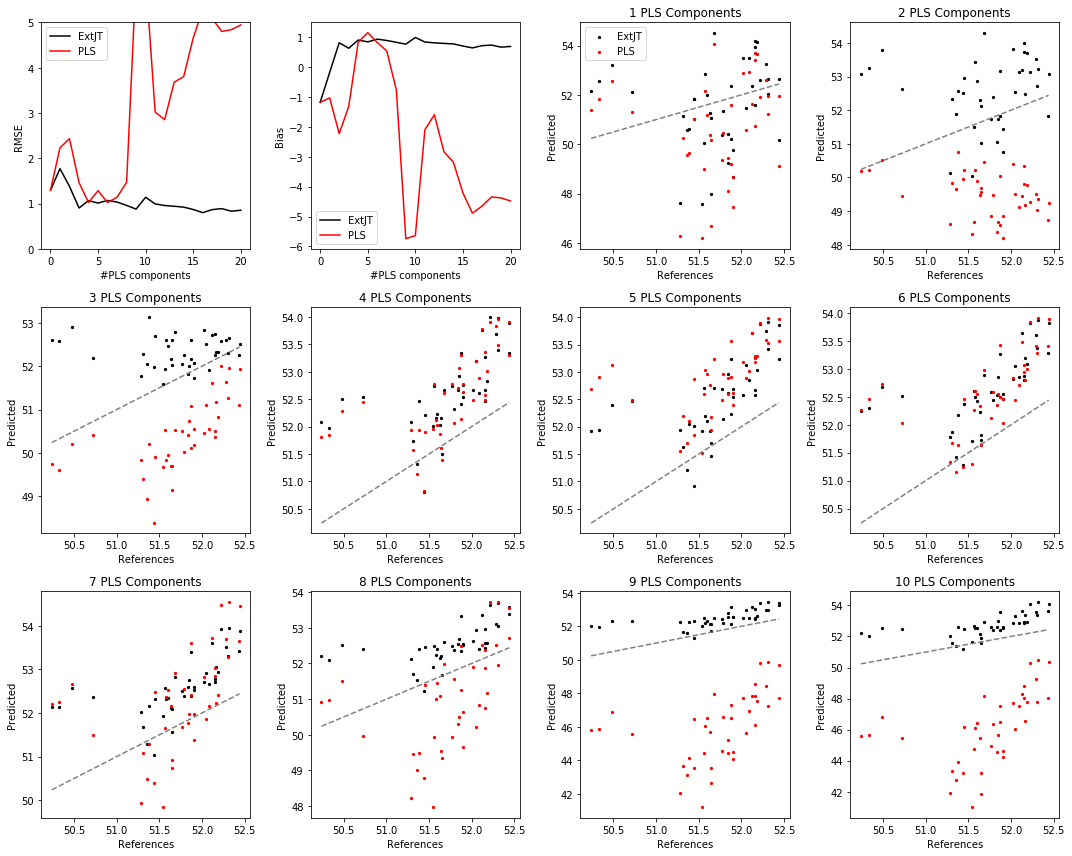

In [5]:
f,ax = plt.subplots(3,4,figsize = (15,12))
ax = ax.flatten()
ax[0].plot(rmseExtJT, c="black", label="ExtJT")
ax[0].plot(rmsePLS, c="red", label="PLS")
ax[0].set_xlabel("#PLS components")
ax[0].set_ylabel("RMSE")
ax[0].set_ylim(0,5)
ax[0].legend()

ax[1].plot(biasExtJT, c="black", label="ExtJT")
ax[1].plot(biasPLS, c="red", label="PLS")
ax[1].set_xlabel("#PLS components")
ax[1].set_ylabel("Bias")
ax[1].legend()
for i in range(1,11):
    ax[i+1].scatter(YV,predsExtJT[:,i], s=5, c="black", label="ExtJT")
    ax[i+1].scatter(YV,predsPLS[:,i],s=5,c="red", label="PLS")
    ax[i+1].plot([YV.min(),YV.max()],[YV.min(),YV.max()],c="gray",ls="--")
    ax[i+1].set_xlabel("References")
    ax[i+1].set_ylabel("Predicted")
    ax[i+1].set_title(f"{i:d} PLS Components")
    if i == 1:
        ax[i+1].legend()
f.tight_layout();


## What happens
Below we illustrate what happens when $\gamma_2$ is changed from a small to a large value. We vary $\gamma_2$ from $10^{-1}$ to $10^{5}$. For small values of $\gamma_2$ the parametrization of the singular values is pushed towards $\gamma_2$, and hence $X_U^{(\gamma_2)}$ is pushed towards the mean spectrum. For large values of $\gamma_2$ the parametrization of the singular values is pushed towards the original singular values. This mean that $X_U^{(\gamma_2)}$ converges to $X_U$.
In terms of manifold regularization, this mean that when $\gamma_2$ is small, the regularization is performed in the direction of the difference in mean values of the labelled and unlablled data. While for larger values of $\gamma_2$ the regularization converges towards the shape of $X_U$.

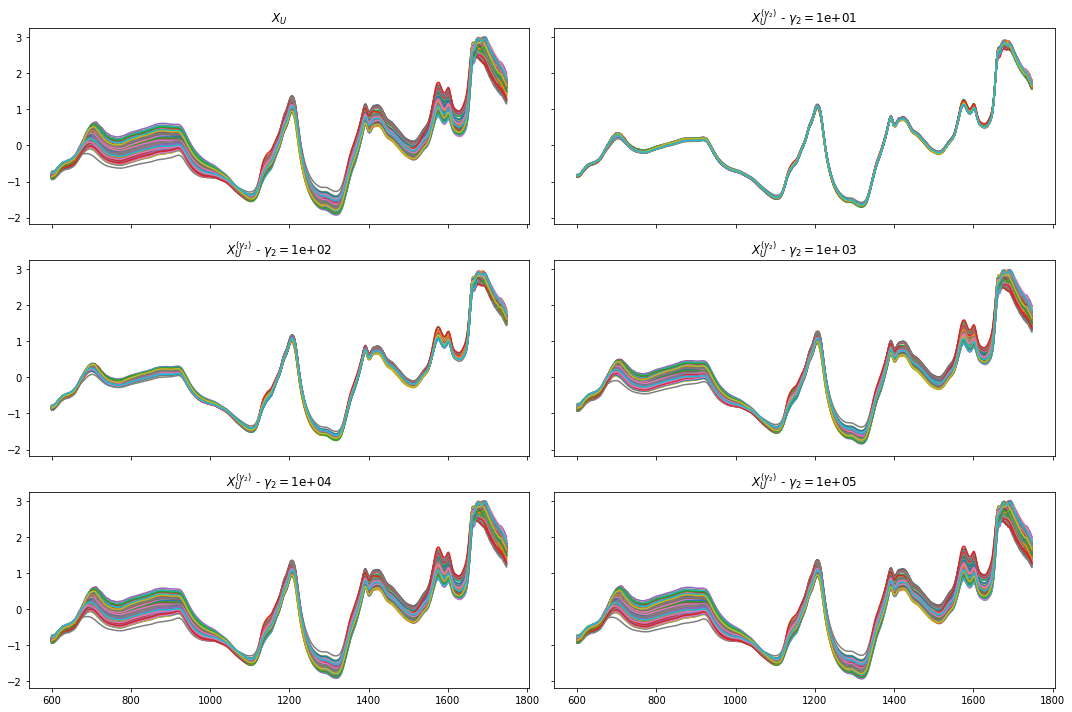

In [6]:
f,ax = plt.subplots(3,2,figsize = (15,10),sharex=True,sharey=True)
ax = ax.flatten()
ax[0].plot(data["Wavelength"],XU.T)
ax[0].set_title(r"$X_U$",fontsize=12)
Uu,Su,Vuh = np.linalg.svd(XU-XU.mean(axis=0),full_matrices=False)
Gamma2 = [1e1,1e2,1e3,1e4,1e5]
for i in range(5):
    gamma2 = Gamma2[i]
    XuGamma2 = gamma2**(1/2)*np.matmul(Uu*(Su**2+gamma2)**(-1/2)*Su,Vuh)+XU.mean(axis=0)
    ax[i+1].plot(data["Wavelength"],XuGamma2.T);
    ax[i+1].set_title(r"$X_U^{(\gamma_2)}$ - $\gamma_2 = $"+f"{gamma2:.0e}",fontsize=12);

f.tight_layout()

## Parameterization of singular values
In order to illustrate exactly how $X_U^{(\gamma_2)}$ converges to $X_U$, we will illustrate the path of the parameterization of the singular values. We see that, as expected, they all start at approximately the same value when $\gamma_2$ is small. When $\gamma_2$ is increased from a small value, the parameterization of large singular increases the most. Thus the variation in the data corresponding large singular values will be introduced before those corresponding to small singular values.

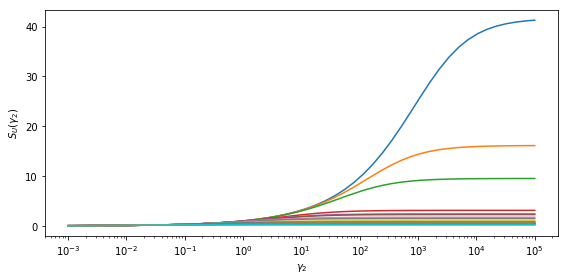

In [7]:
Uu,Su,Vuh = np.linalg.svd(XU-XU.mean(axis=0),full_matrices=False)
Gamma2 = [10**i for i in np.linspace(-3,5,num=50)]
SuGamma2 = []
for i in range(len(Gamma2)):
    gamma2 = Gamma2[i]
    SuGamma2.append(gamma2**(1/2)*(Su**2+gamma2)**(-1/2)*Su)
SuGamma2 = np.array(SuGamma2)

f,ax = plt.subplots(1,1,figsize = (8,4))
ax.semilogx(Gamma2,SuGamma2[:,:20])
ax.set_xlabel(r"$\gamma_2$")
ax.set_ylabel(r"$S_U(\gamma_2$)")
f.tight_layout();
